# Creating and Backtesting MACD Strategies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
data = pd.read_csv("eurusd.csv", parse_dates = ["Date"], index_col = "Date")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4275 entries, 2004-01-01 to 2020-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4275 non-null   float64
dtypes: float64(1)
memory usage: 66.8 KB


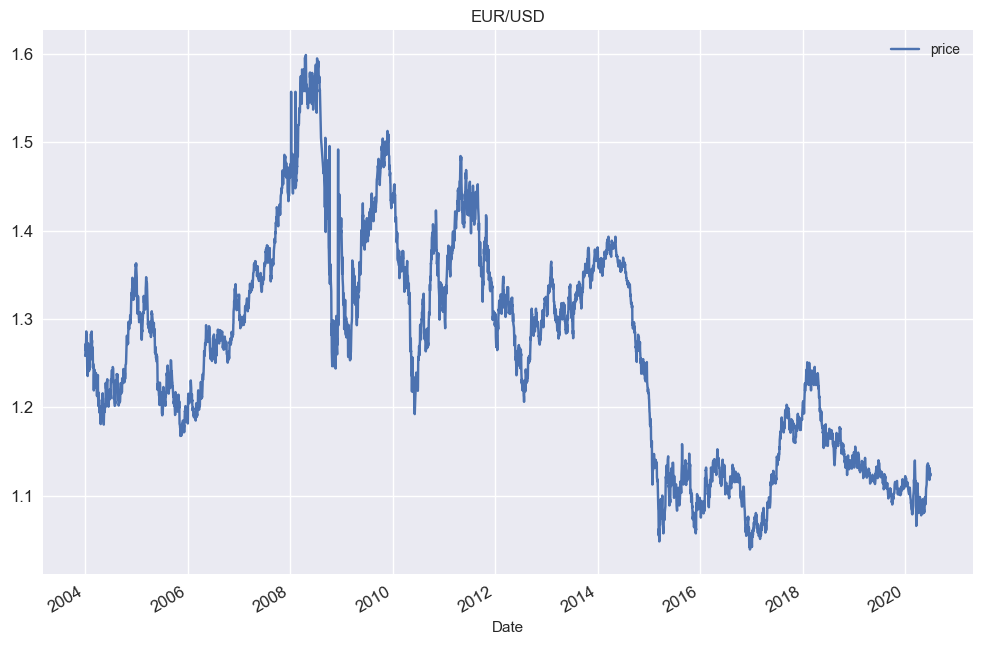

In [4]:
data.plot(figsize = (12, 8), title = "EUR/USD", fontsize = 12)
plt.show()

## Defining an MACD Strategy

In [6]:
ema_s = 12 # EMA Short
ema_l = 26 # EMA Long

In [7]:
data["EMA_S"] = data.price.ewm(span = ema_s, min_periods = ema_s).mean() 

In [8]:
data["EMA_L"] = data.price.ewm(span = ema_l, min_periods = ema_l).mean() 

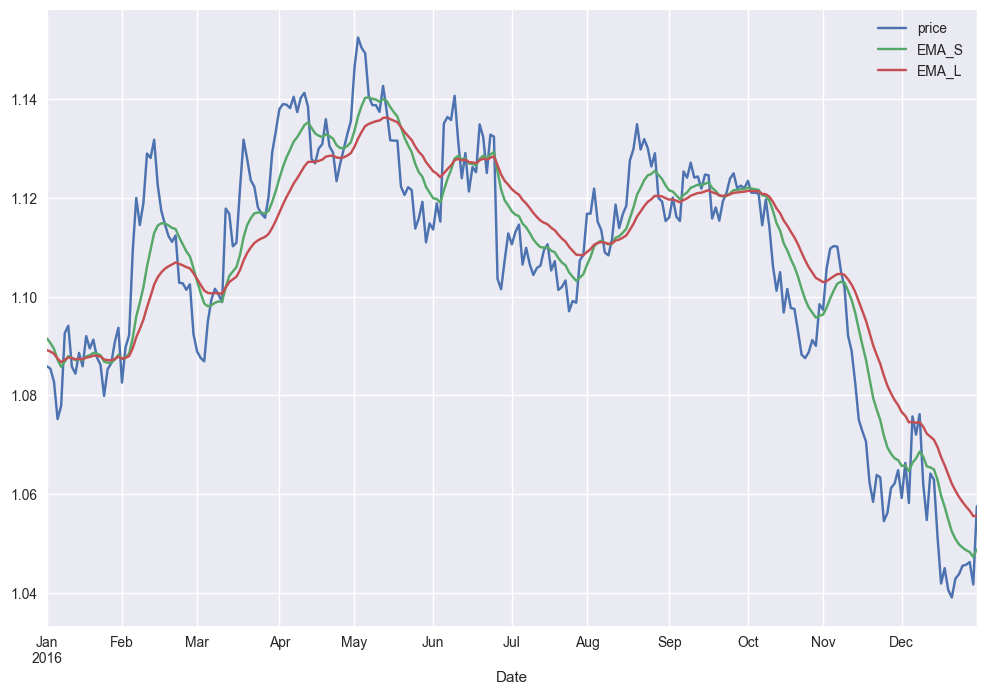

In [9]:
data.loc["2016", ["price", "EMA_S", "EMA_L"]].plot(figsize = (12, 8))
plt.show()

In [10]:
data["MACD"] = data.EMA_S - data.EMA_L

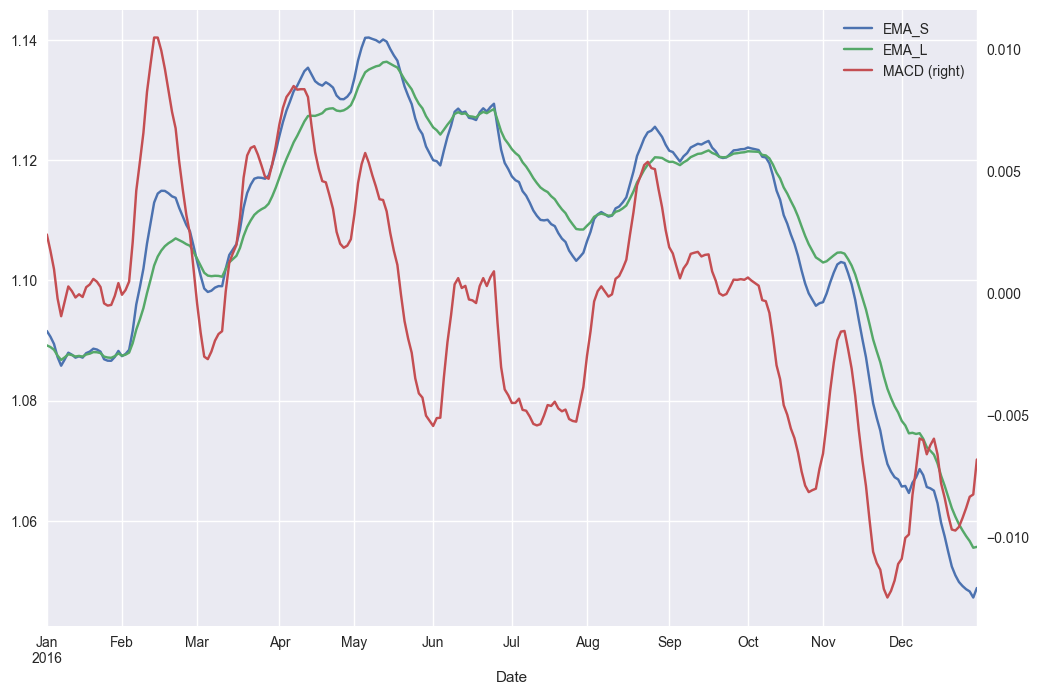

In [11]:
data.loc["2016", ["EMA_S", "EMA_L", "MACD"]].plot(figsize = (12, 8), secondary_y = "MACD")
plt.show()

In [12]:
signal_mw = 9 # Moving Window for Signal Line

In [13]:
data["MACD_Signal"] = data.MACD.ewm(span = signal_mw, min_periods = signal_mw).mean() 

In [14]:
data

,price,EMA_S,EMA_L,MACD,MACD_Signal
Date,,,,,
2004-01-01,1.258194,NaN,NaN,NaN,NaN
2004-01-02,1.258194,NaN,NaN,NaN,NaN
2004-01-05,1.268698,NaN,NaN,NaN,NaN
2004-01-06,1.272103,NaN,NaN,NaN,NaN
2004-01-07,1.264095,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-06-24,1.131235,1.125123,1.117852,0.007272,0.008516
2020-06-25,1.125087,1.125118,1.118388,0.006730,0.008158
2020-06-26,1.122208,1.124670,1.118671,0.005999,0.007727


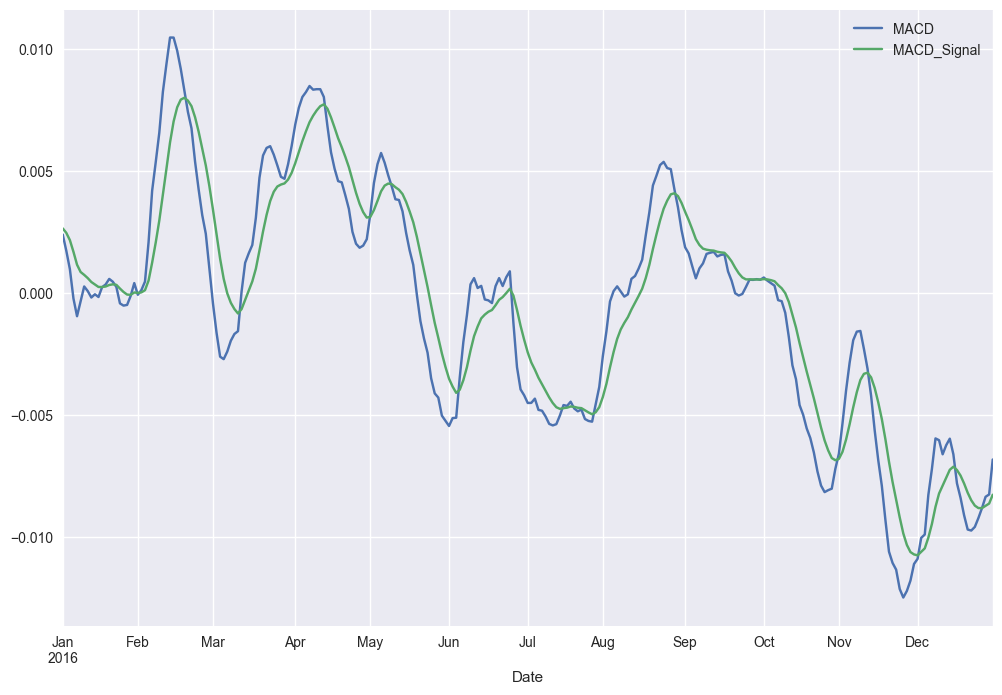

In [15]:
data.loc["2016", ["MACD", "MACD_Signal"]].plot(figsize = (12, 8))
plt.show()

In [16]:
data["position"] = np.where(data.MACD - data.MACD_Signal > 0, 1, -1)

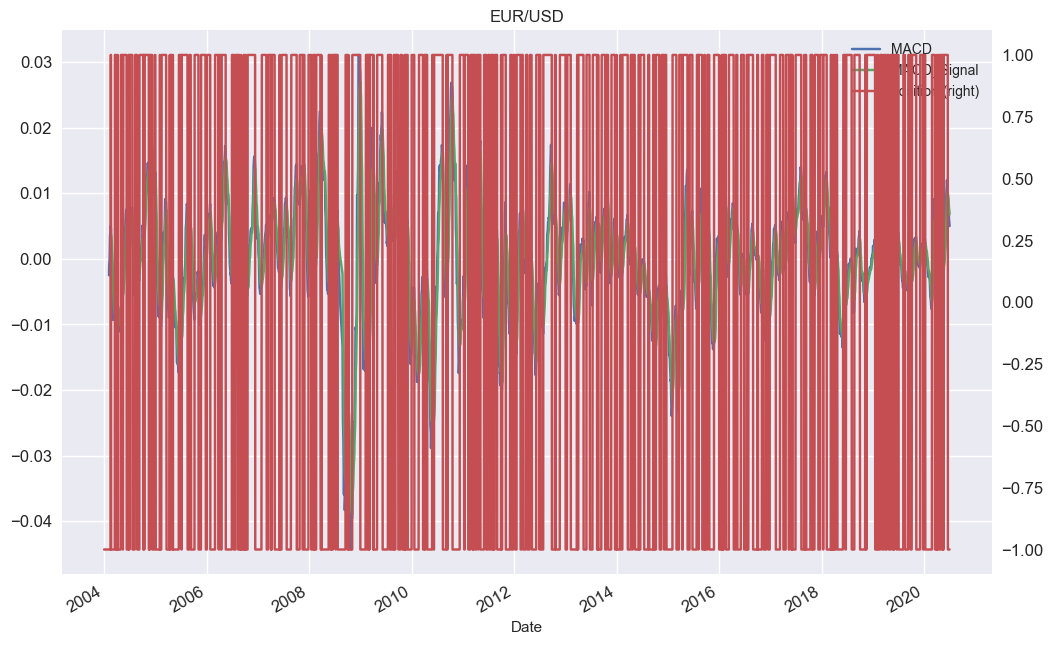

In [17]:
data.loc[:, ["MACD", "MACD_Signal", "position"]].plot(figsize = (12, 8), fontsize = 12, 
                                                      secondary_y = "position", title = "EUR/USD")
plt.show()

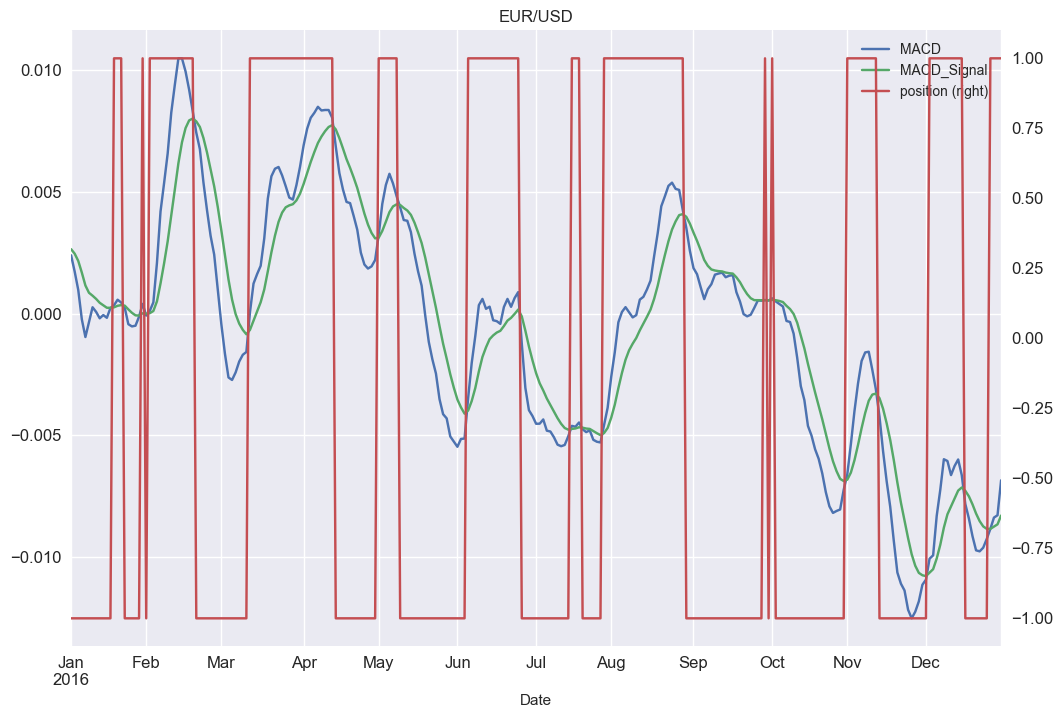

In [18]:
data.loc["2016", ["MACD", "MACD_Signal", "position"]].plot(figsize = (12, 8), fontsize = 12,
                                                           secondary_y = "position", title = "EUR/USD")
plt.show()

## Vectorized Strategy Backtesting

In [19]:
data["returns"] = np.log(data.price.div(data.price.shift(1)))

In [20]:
data.dropna(inplace = True)

In [21]:
data["strategy"] = data.position.shift(1) * data["returns"]

In [22]:
data.dropna(inplace = True)

In [23]:
ptc = 0.00007

In [24]:
data["trades"] = data.position.diff().fillna(0).abs()

In [25]:
data.trades.value_counts()

trades
0.0    3864
2.0     377
Name: count, dtype: int64

In [26]:
data["strategy_net"] = data.strategy - data.trades * ptc

In [27]:
data["creturns"] = data["returns"].cumsum().apply(np.exp)
data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
data["cstrategy_net"] = data["strategy_net"].cumsum().apply(np.exp)

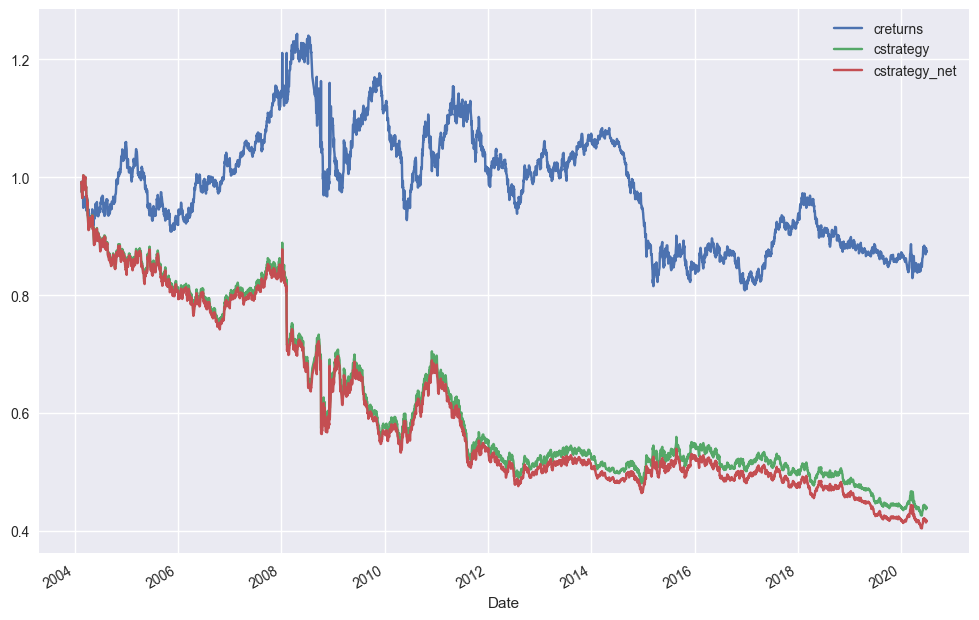

In [28]:
data[["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12 , 8))
plt.show()

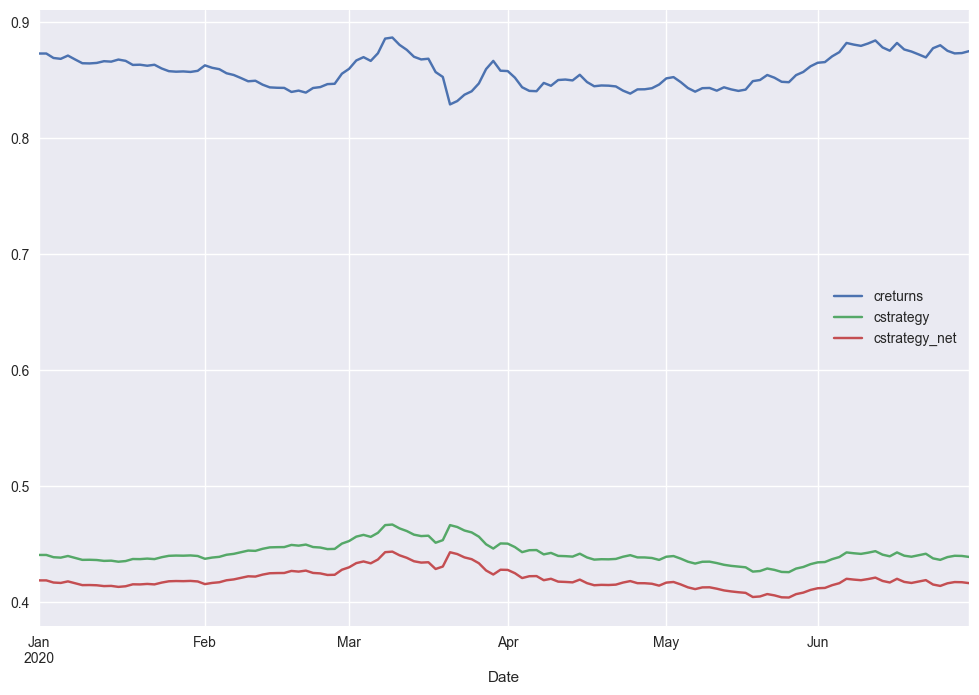

In [29]:
data.loc["2020", ["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12 , 8))
plt.show()

### Using the MACD Backtester class

In [1]:
from MACDBacktester import MACDBacktester as MACD

In [4]:
ptc = 0.00007

In [5]:
tester = MACD("EURUSD=X", EMA_S = 12, EMA_L = 26, signal_mw = 9,
              start = "2004-01-01", end = "2020-06-30", tc = ptc)

In [6]:
tester

MACDBacktester(symbol = EURUSD=X, MACD(12, 26, 9), start = 2004-01-01, end = 2020-06-30)

In [7]:
tester.test_strategy()

(0.416605, -0.458123)

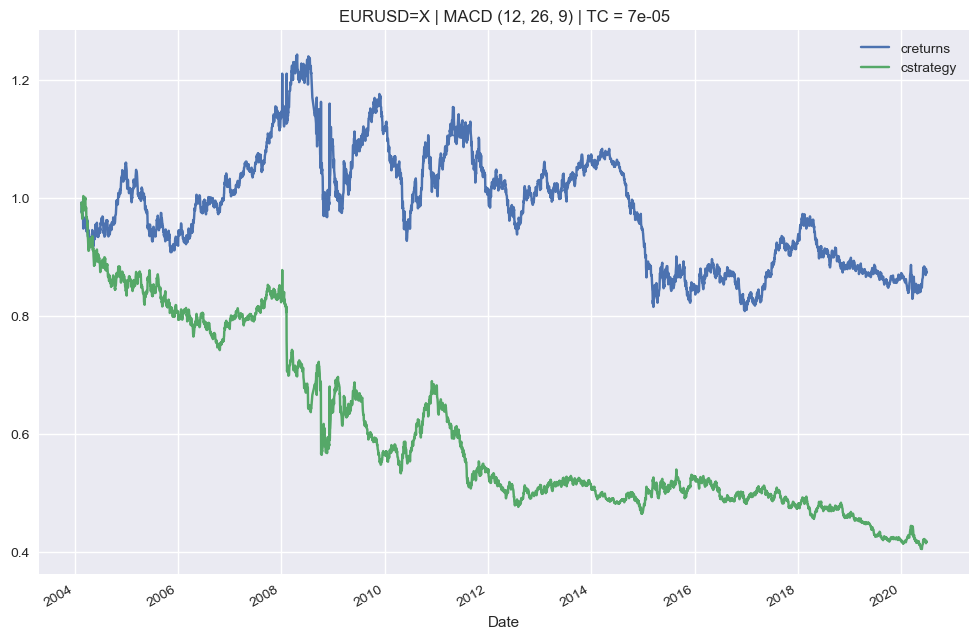

In [8]:
tester.plot_results()

In [9]:
tester.results

,price,returns,EMA_S,EMA_L,MACD,MACD_Signal,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,,
2004-02-18,1.272508,-0.010386,1.271449,1.266693,0.004756,0.003408,1,-0.010386,0.0,0.989667,0.989667
2004-02-19,1.275705,0.002510,1.272106,1.267405,0.004700,0.003691,1,0.002510,0.0,0.992154,0.992154
2004-02-20,1.254202,-0.017000,1.269345,1.266367,0.002978,0.003538,-1,-0.017140,2.0,0.975430,0.975294
2004-02-23,1.257197,0.002386,1.267473,1.265649,0.001824,0.003175,-1,-0.002386,0.0,0.977760,0.972969
2004-02-24,1.267797,0.008395,1.267523,1.265817,0.001706,0.002868,-1,-0.008395,0.0,0.986003,0.964835
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-24,1.131235,0.002892,1.125123,1.117852,0.007272,0.008516,-1,-0.002892,0.0,0.879795,0.414206
2020-06-25,1.125087,-0.005449,1.125118,1.118388,0.006730,0.008158,-1,0.005449,0.0,0.875014,0.416470
2020-06-26,1.122208,-0.002562,1.124670,1.118671,0.005999,0.007727,-1,0.002562,0.0,0.872775,0.417538


In [10]:
tester.optimize_parameters((5, 20, 1), (21, 50, 1), (5, 20, 1))

(array([18., 30., 19.]), 0.760579)

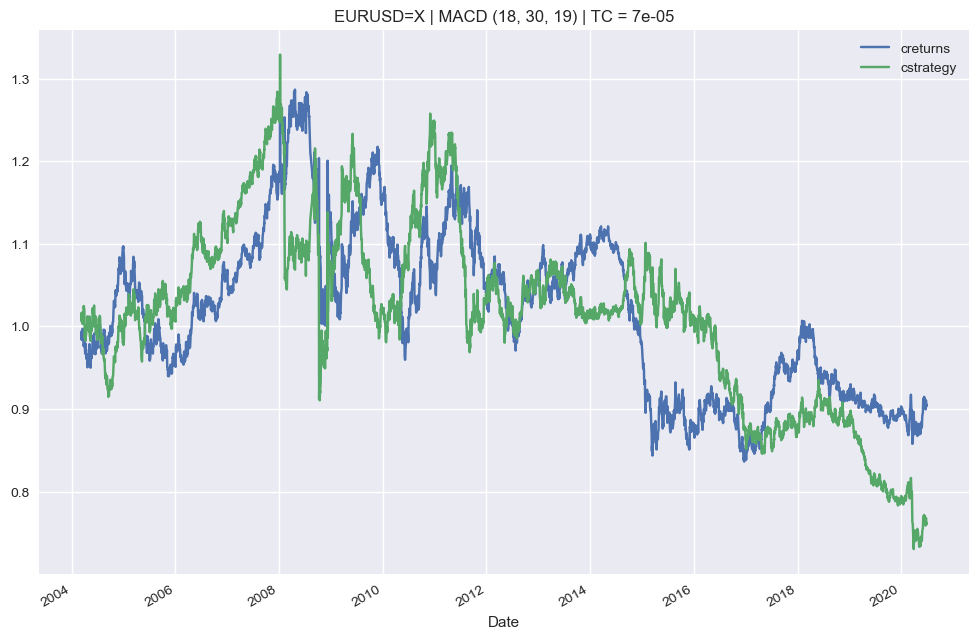

In [11]:
tester.plot_results()

__AUD / EUR__

In [12]:
tester = MACD("AUDEUR=X", EMA_S = 12, EMA_L = 26, signal_mw = 9, 
              start = "2004-01-01", end = "2020-06-30", tc = 0)

In [13]:
tester.test_strategy()

(1.061038, 0.076032)

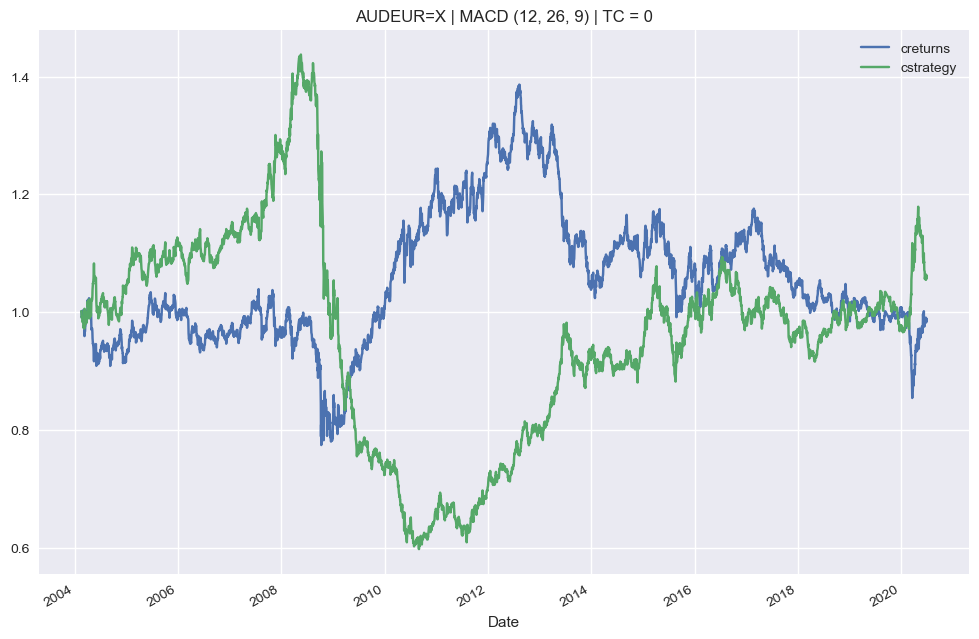

In [14]:
tester.plot_results()

In [15]:
tester.optimize_parameters((5, 20, 1), (21, 50, 1), (5, 20, 1))

(array([ 5., 23.,  6.]), 2.183987)

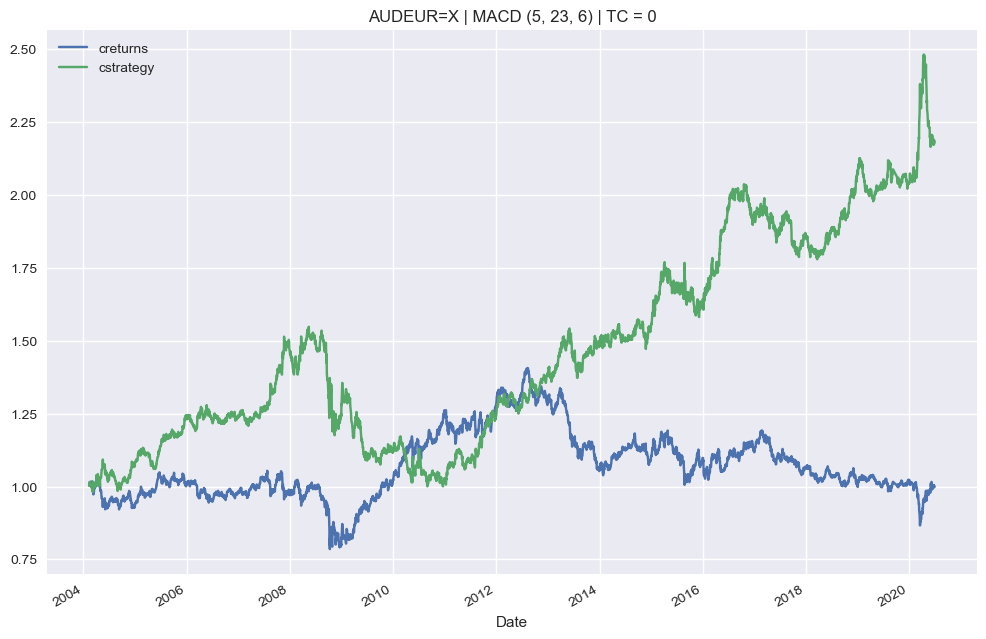

In [16]:
tester.plot_results()

__Optimization and Backtesting (2004-2014)__ ("In-Sample")

In [17]:
tester = MACD("AUDEUR=X", EMA_S = 12, EMA_L = 26, signal_mw = 9,
              start = "2004-01-01", end = "2014-12-31", tc = 0)

In [18]:
tester.optimize_parameters((5, 20, 1), (21, 50, 1), (5, 20, 1))

(array([ 6., 24.,  7.]), 1.56004)

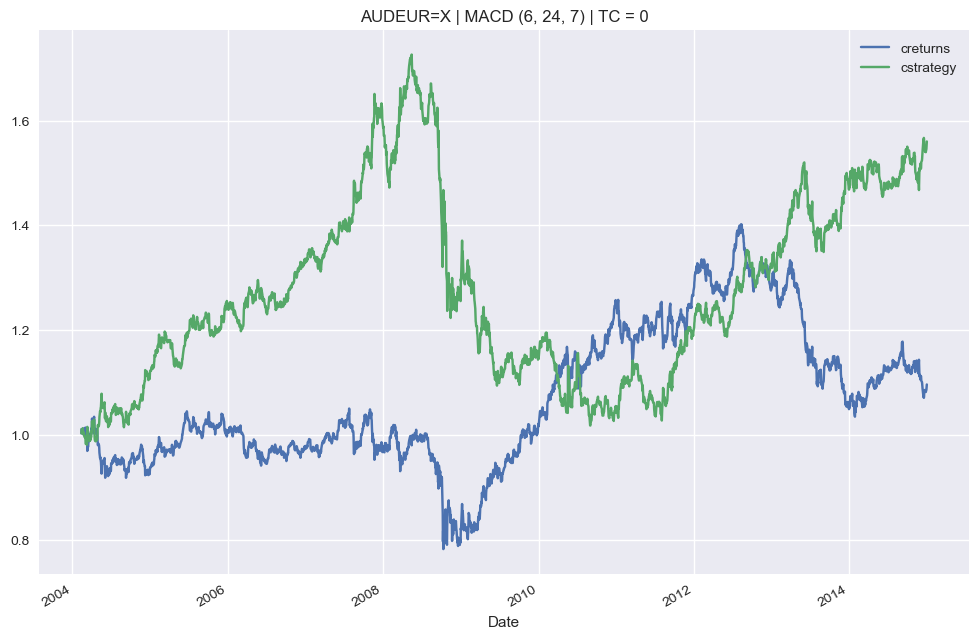

In [19]:
tester.plot_results()

__Forward Testing (2015-2020)__ ("Out-Sample")

In [20]:
forwardtester = MACD("AUDEUR=X", EMA_S = 6, EMA_L = 24, signal_mw = 7,
                     start = "2015-01-01", end = "2020-06-30", tc = 0)

In [21]:
forwardtester.test_strategy()

(1.237419, 0.348736)

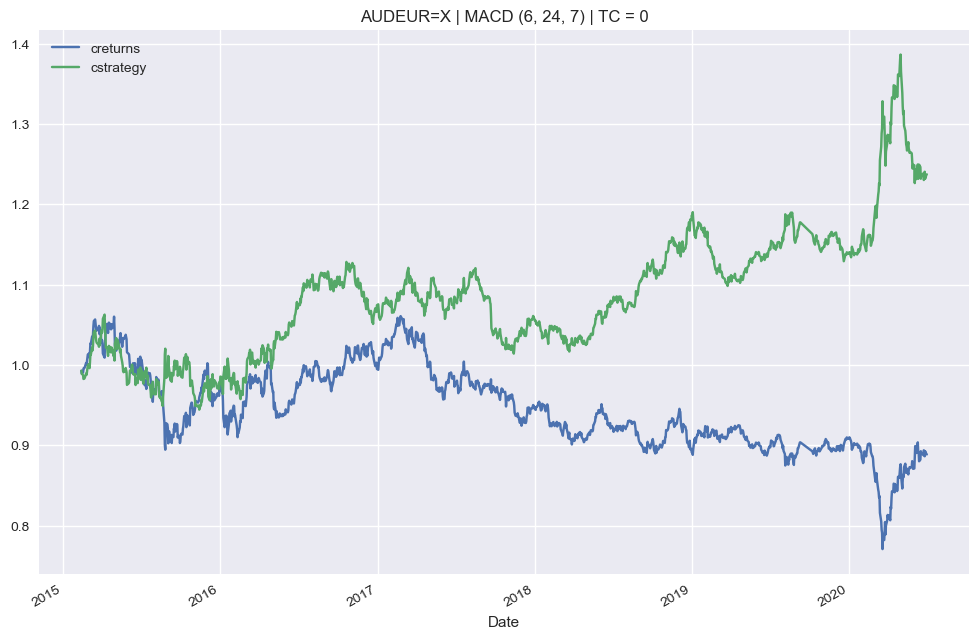

In [22]:
forwardtester.plot_results()